In [1]:
import urllib
import json
token = '83d56b3983d56b3983d56b396883bf30f4883d583d56b39df190c359943d1ddc6e0eb44'
version = '5.92'
group = '-116496582'

In [4]:
posts = []
offsets = [0, 100, 200]
for off in offsets:
    req = urllib.request.Request('https://api.vk.com/method/wall.get?owner_id=%s&offset=%s&count=100&v=%s&access_token=%s' % (group, off, version, token))
    response = urllib.request.urlopen(req)
    result = response.read().decode('utf-8')
    data = json.loads(result) 
    posts.append(data['response']['items'])
posts_flat = []
for i in range(len(posts)):
    if len(posts[i])!=0:
        for j in range(len(posts[i])):
            posts_flat.append(posts[i][j])

In [5]:
post_ids = []
for post in posts_flat:
    post_ids.append(post['id'])

In [8]:
len(posts_flat)

300

In [9]:
comments = []
for post_id in post_ids:
    req = urllib.request.Request('https://api.vk.com/method/wall.getComments?owner_id=%s&post_id=%s&count=100&v=%s&access_token=%s' % (group, post_id, version, token))
    response = urllib.request.urlopen(req)
    result = response.read().decode('utf-8')
    data = json.loads(result) 
    comments.append(data['response']['items'])
comments_flat = []
for i in range(len(comments)):
    if len(comments[i])!=0:
        for j in range(len(comments[i])):
            comments_flat.append(comments[i][j])

In [41]:
comments_flat = [c for c in comments_flat if 'text' in c.keys()]

#### Токенизация и удаление стоп-слов

In [99]:
from nltk.tokenize import word_tokenize
import nltk
from string import punctuation
with open('rus_stopwords.txt', 'r', encoding='utf-8') as f:
    stopwords = f.read().splitlines()

In [100]:
post_texts = []
for post in posts_flat:
    text = post['text']
    text = text.lower()
    text = word_tokenize(text)
    text = [w for w in text if w not in punctuation]
    post_texts.append(text)

In [101]:
post_texts_new = []
for text in post_texts:
    new = [token for token in text if token not in stopwords]
    post_texts_new.append(new)

In [116]:
comment_averages = []
for i in post_ids:
    id_comments = [c for c in comments_flat if c['post_id']==i]
    texts = [post['text'] for post in id_comments]
    texts = ' '.join(texts).split()
    texts = [text.lower() for text in texts]
    texts = [word_tokenize(text) for text in texts]
    if len(id_comments)>0:
        comment_averages.append(len(texts)/len(id_comments))
    else:
        comment_averages.append(0)

### График со средними длинами постов

In [117]:
post_lengths = []
for text in post_texts_new:
    post_lengths.append(len(text))

In [118]:
post_ids = [str(i) for i in post_ids]

In [119]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')
colors = sns.color_palette('viridis', max(post_lengths)) 

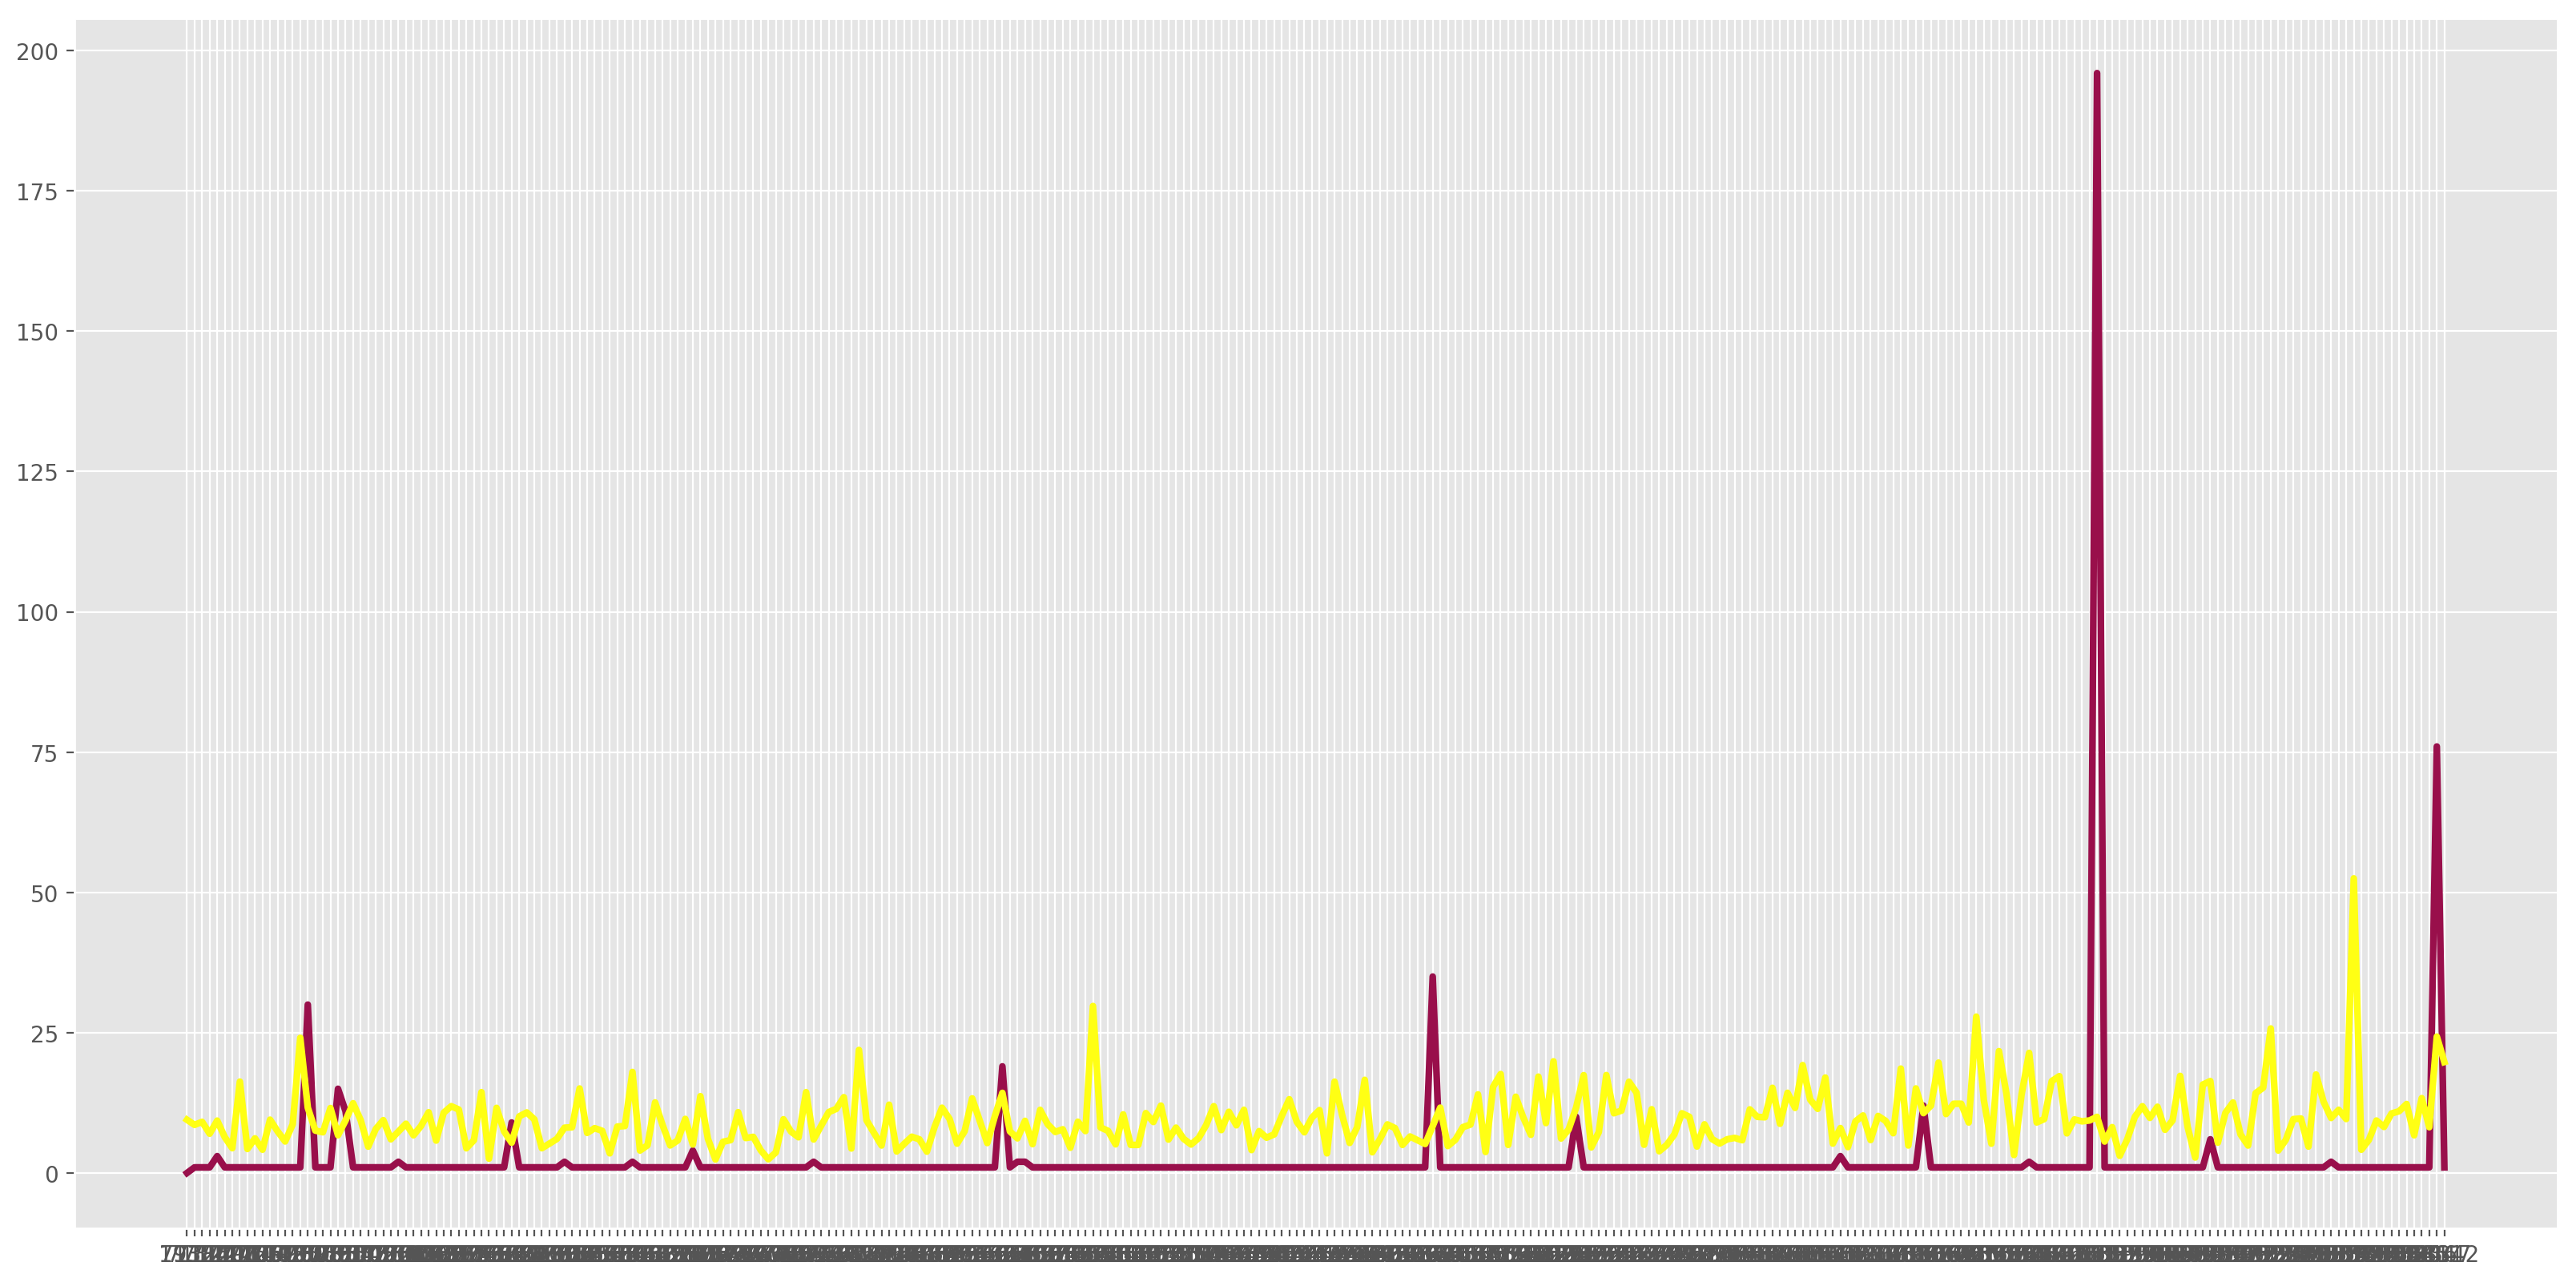

In [120]:
plt.figure(figsize=(20, 10), dpi=200)
plt.plot(post_ids, post_lengths, c='xkcd:berry', linewidth='3')
plt.plot(post_ids, comment_averages, c='xkcd:yellow', linewidth='3')

### Наиболее частотные слова

In [121]:
from collections import Counter
post_corpus = ' '.join([' '.join(t) for t in post_texts]).split()

In [122]:
word_count = Counter(post_corpus).most_common(30)
words = [w[0] for w in word_count]
numbers = [w[1] for w in word_count]

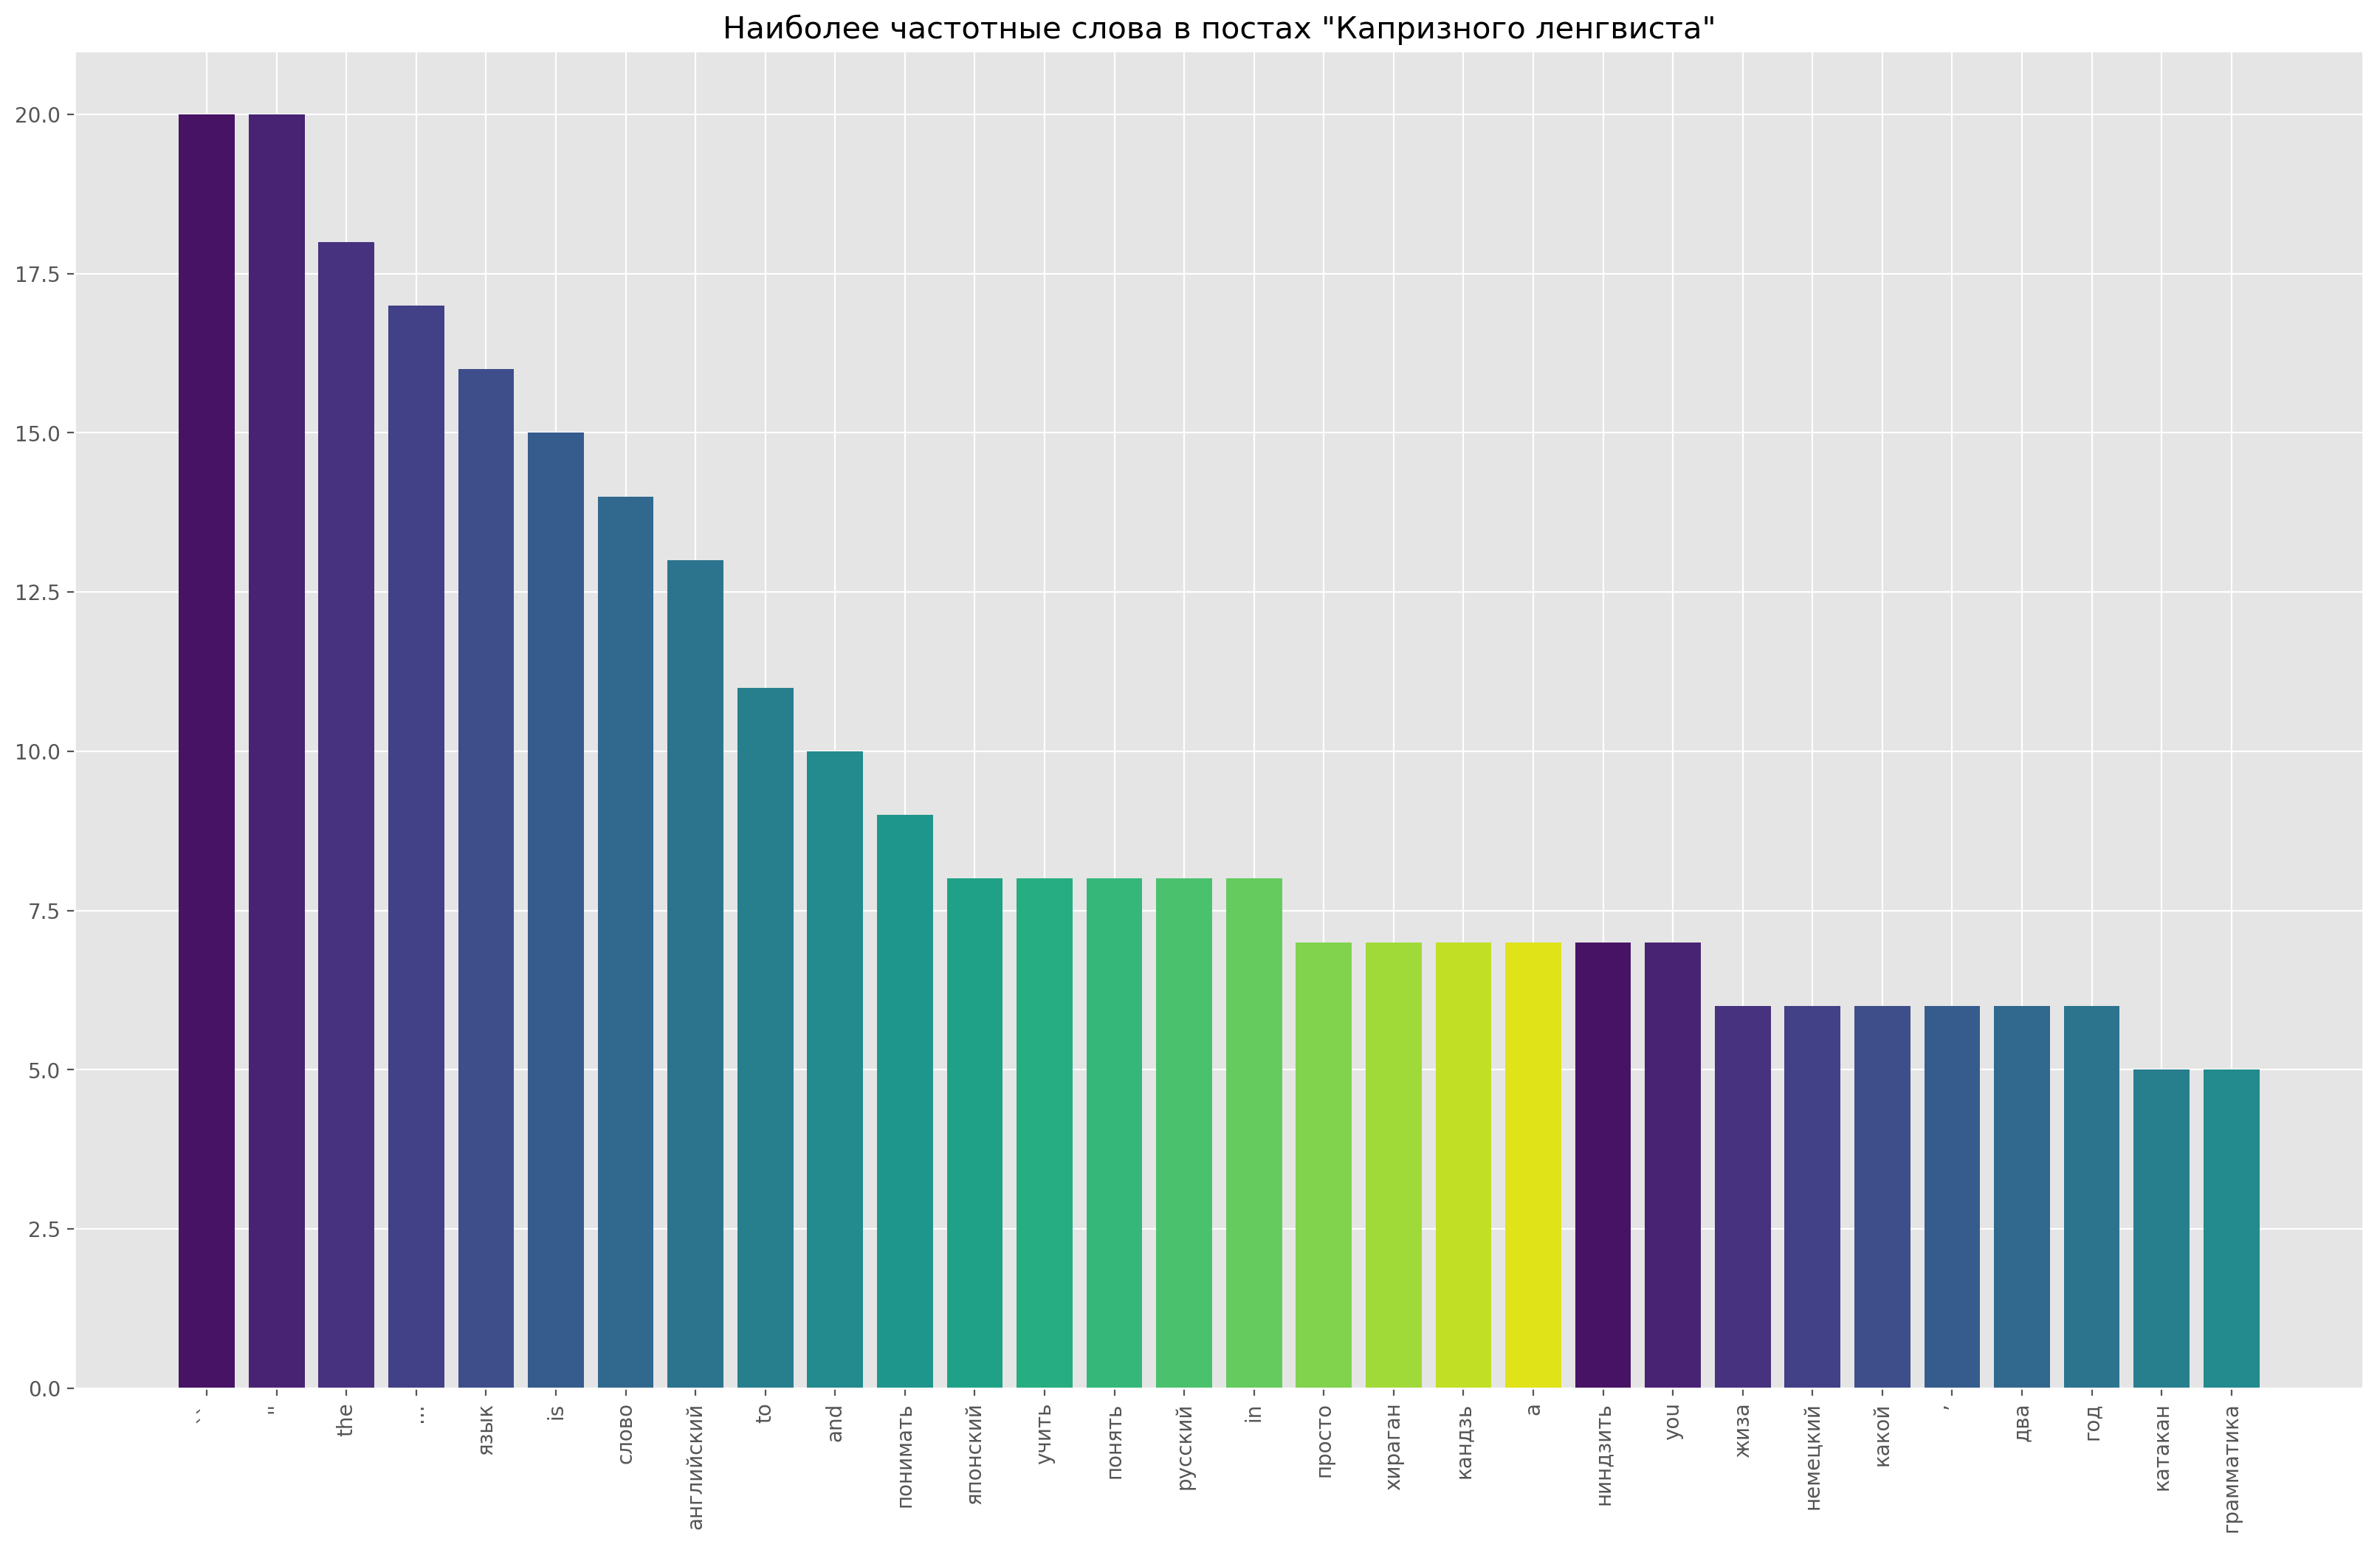

In [146]:
colors = sns.color_palette('viridis', max(numbers)) 
plt.figure(figsize=(20, 12), dpi=200)
plt.bar(words, numbers, color=colors)
plt.title('Наиболее частотные слова в постах "Капризного ленгвиста"', fontsize=15)
plt.xticks(rotation=90, fontsize = 10)
plt.savefig('words_posts.png')

In [147]:
comment_corpus = ' '.join([' '.join(t) for t in comment_texts]).split()
comment_corpus = [c for c in comment_corpus if c not in punctuation]
comment_corpus = [token for token in comment_corpus if token not in stopwords]
word_count = Counter(comment_corpus).most_common(30)
words = [w[0] for w in word_count]
numbers = [w[1] for w in word_count]

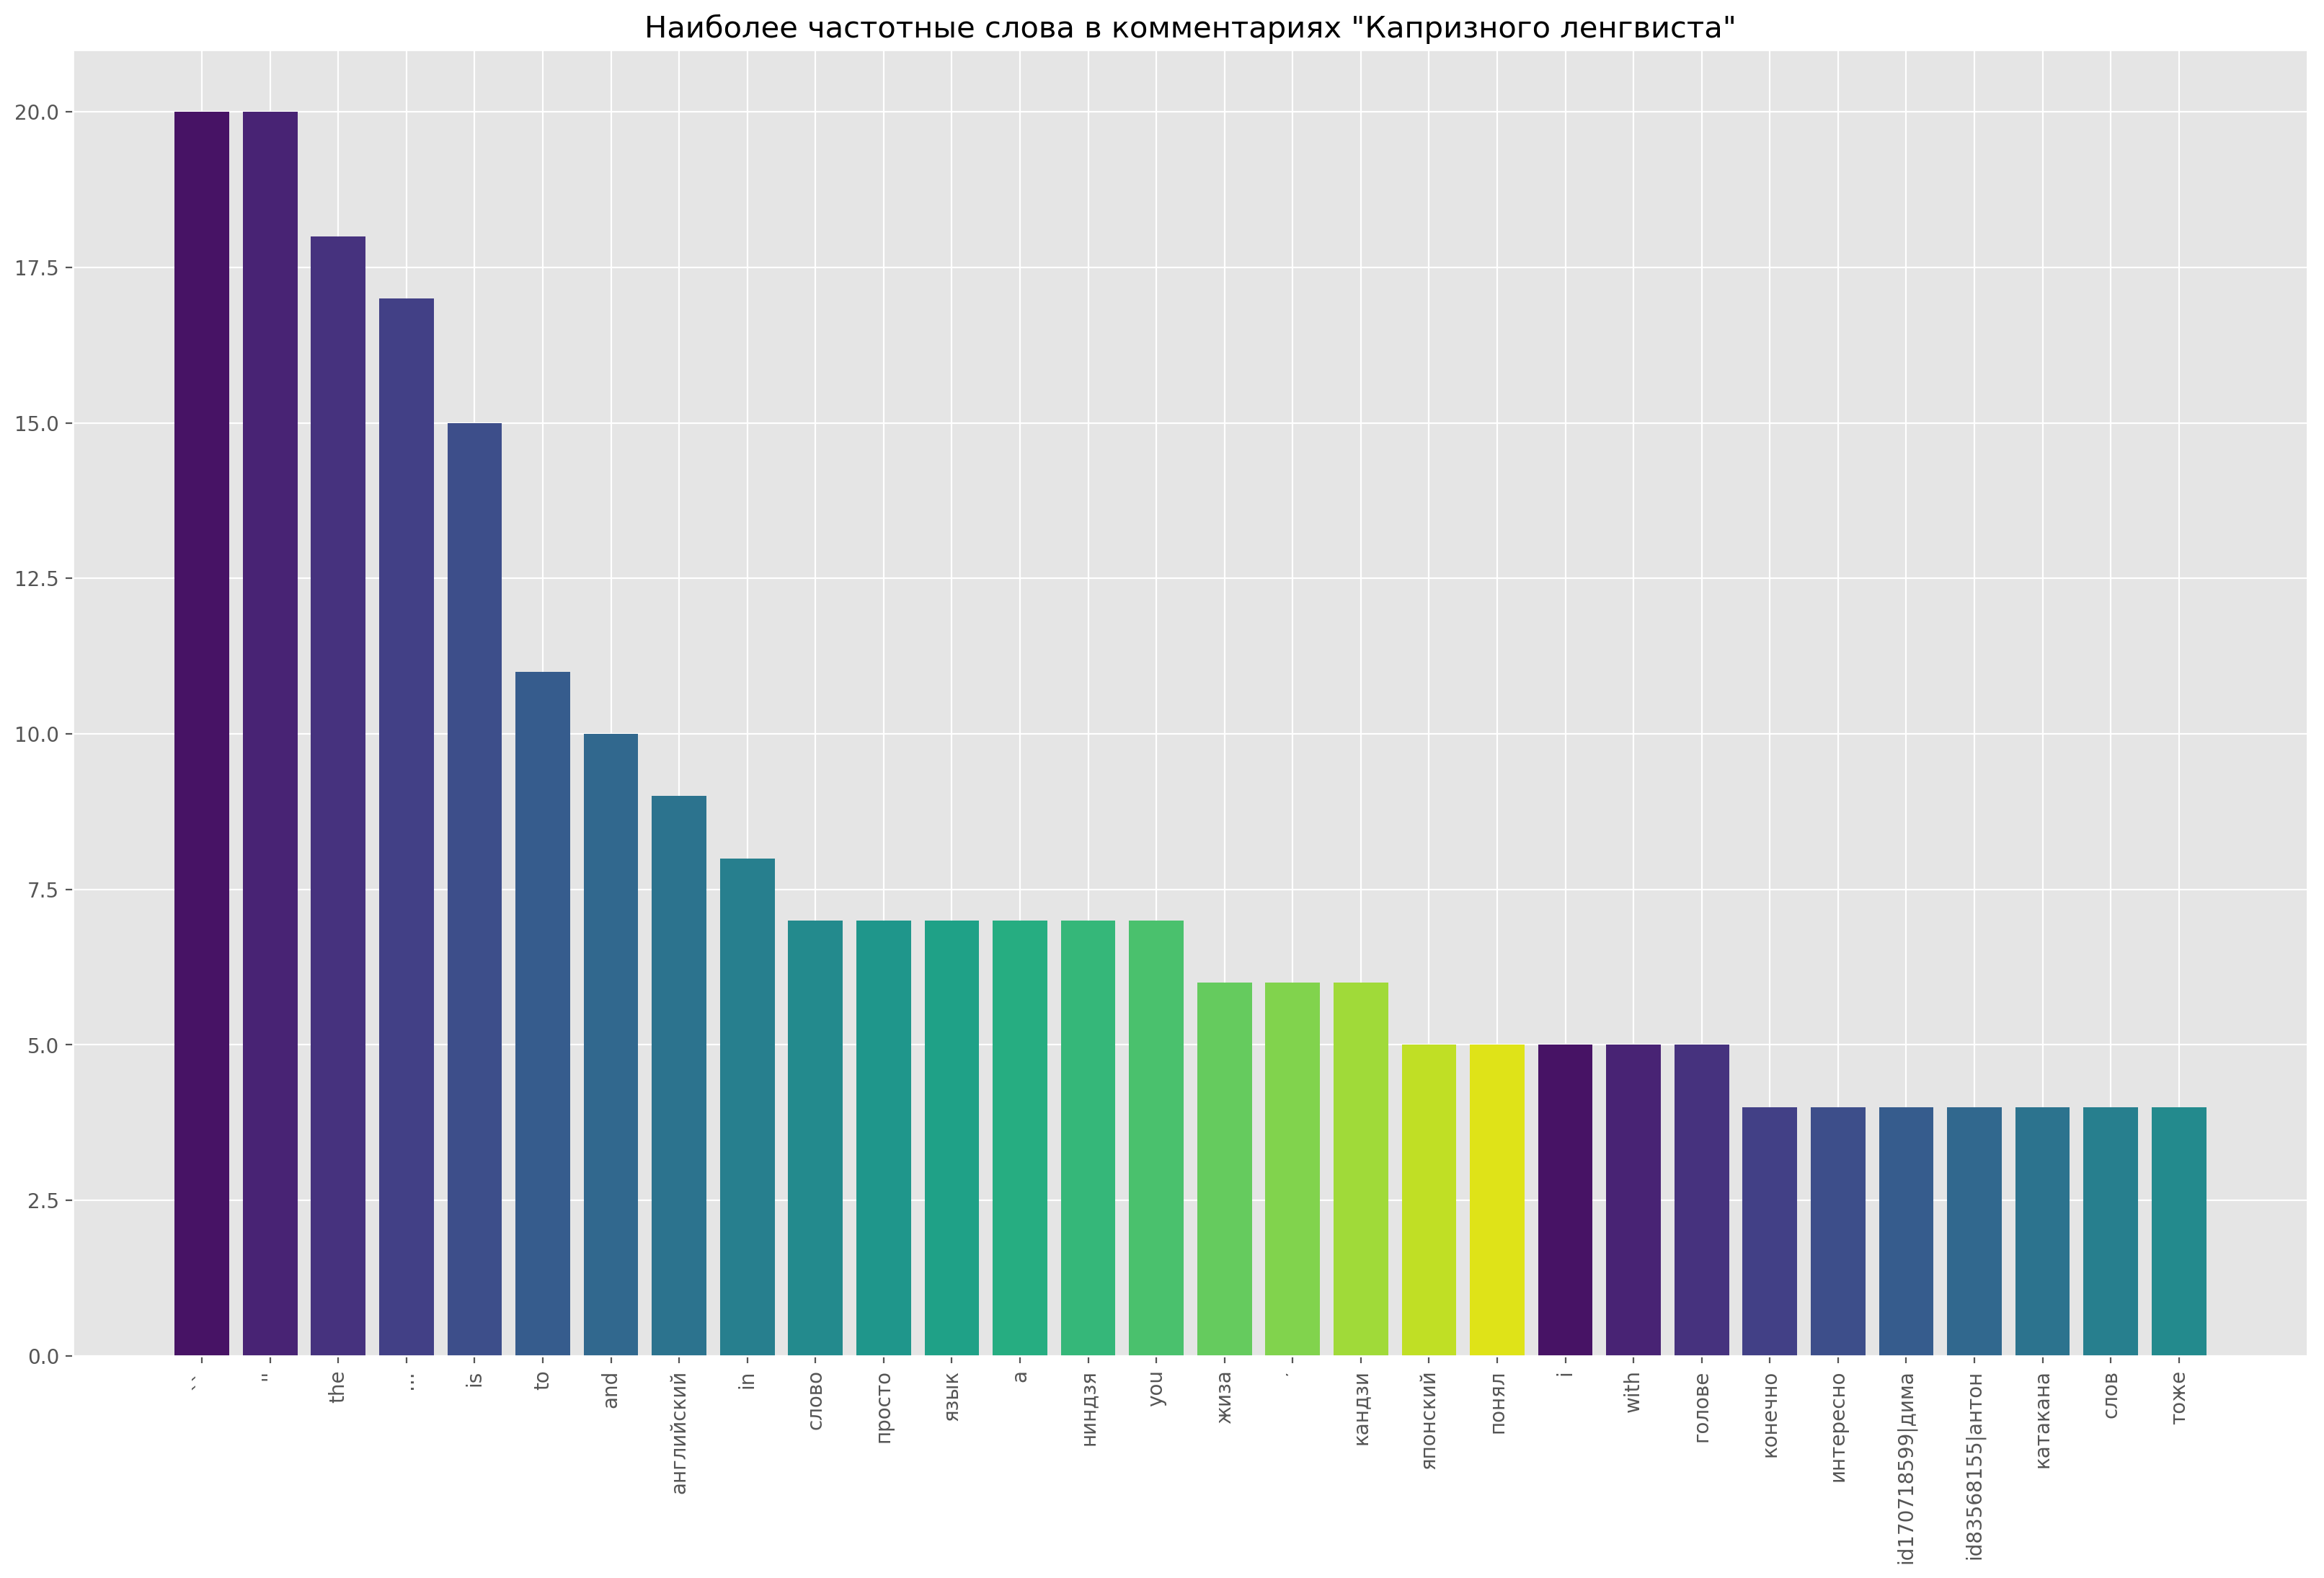

In [148]:
colors = sns.color_palette('viridis', max(numbers)) 
plt.figure(figsize=(20, 12), dpi=200)
plt.bar(words, numbers, color=colors)
plt.title('Наиболее частотные слова в комментариях "Капризного ленгвиста"', fontsize=15)
plt.xticks(rotation=90, fontsize = 10)
plt.savefig('words_comments.png')

### Подсчет частотных лемм

In [149]:
from pymorphy2 import MorphAnalyzer
morph = MorphAnalyzer()

In [150]:
 clean_posts = [morph.parse(token)[0].normal_form for token in post_corpus]

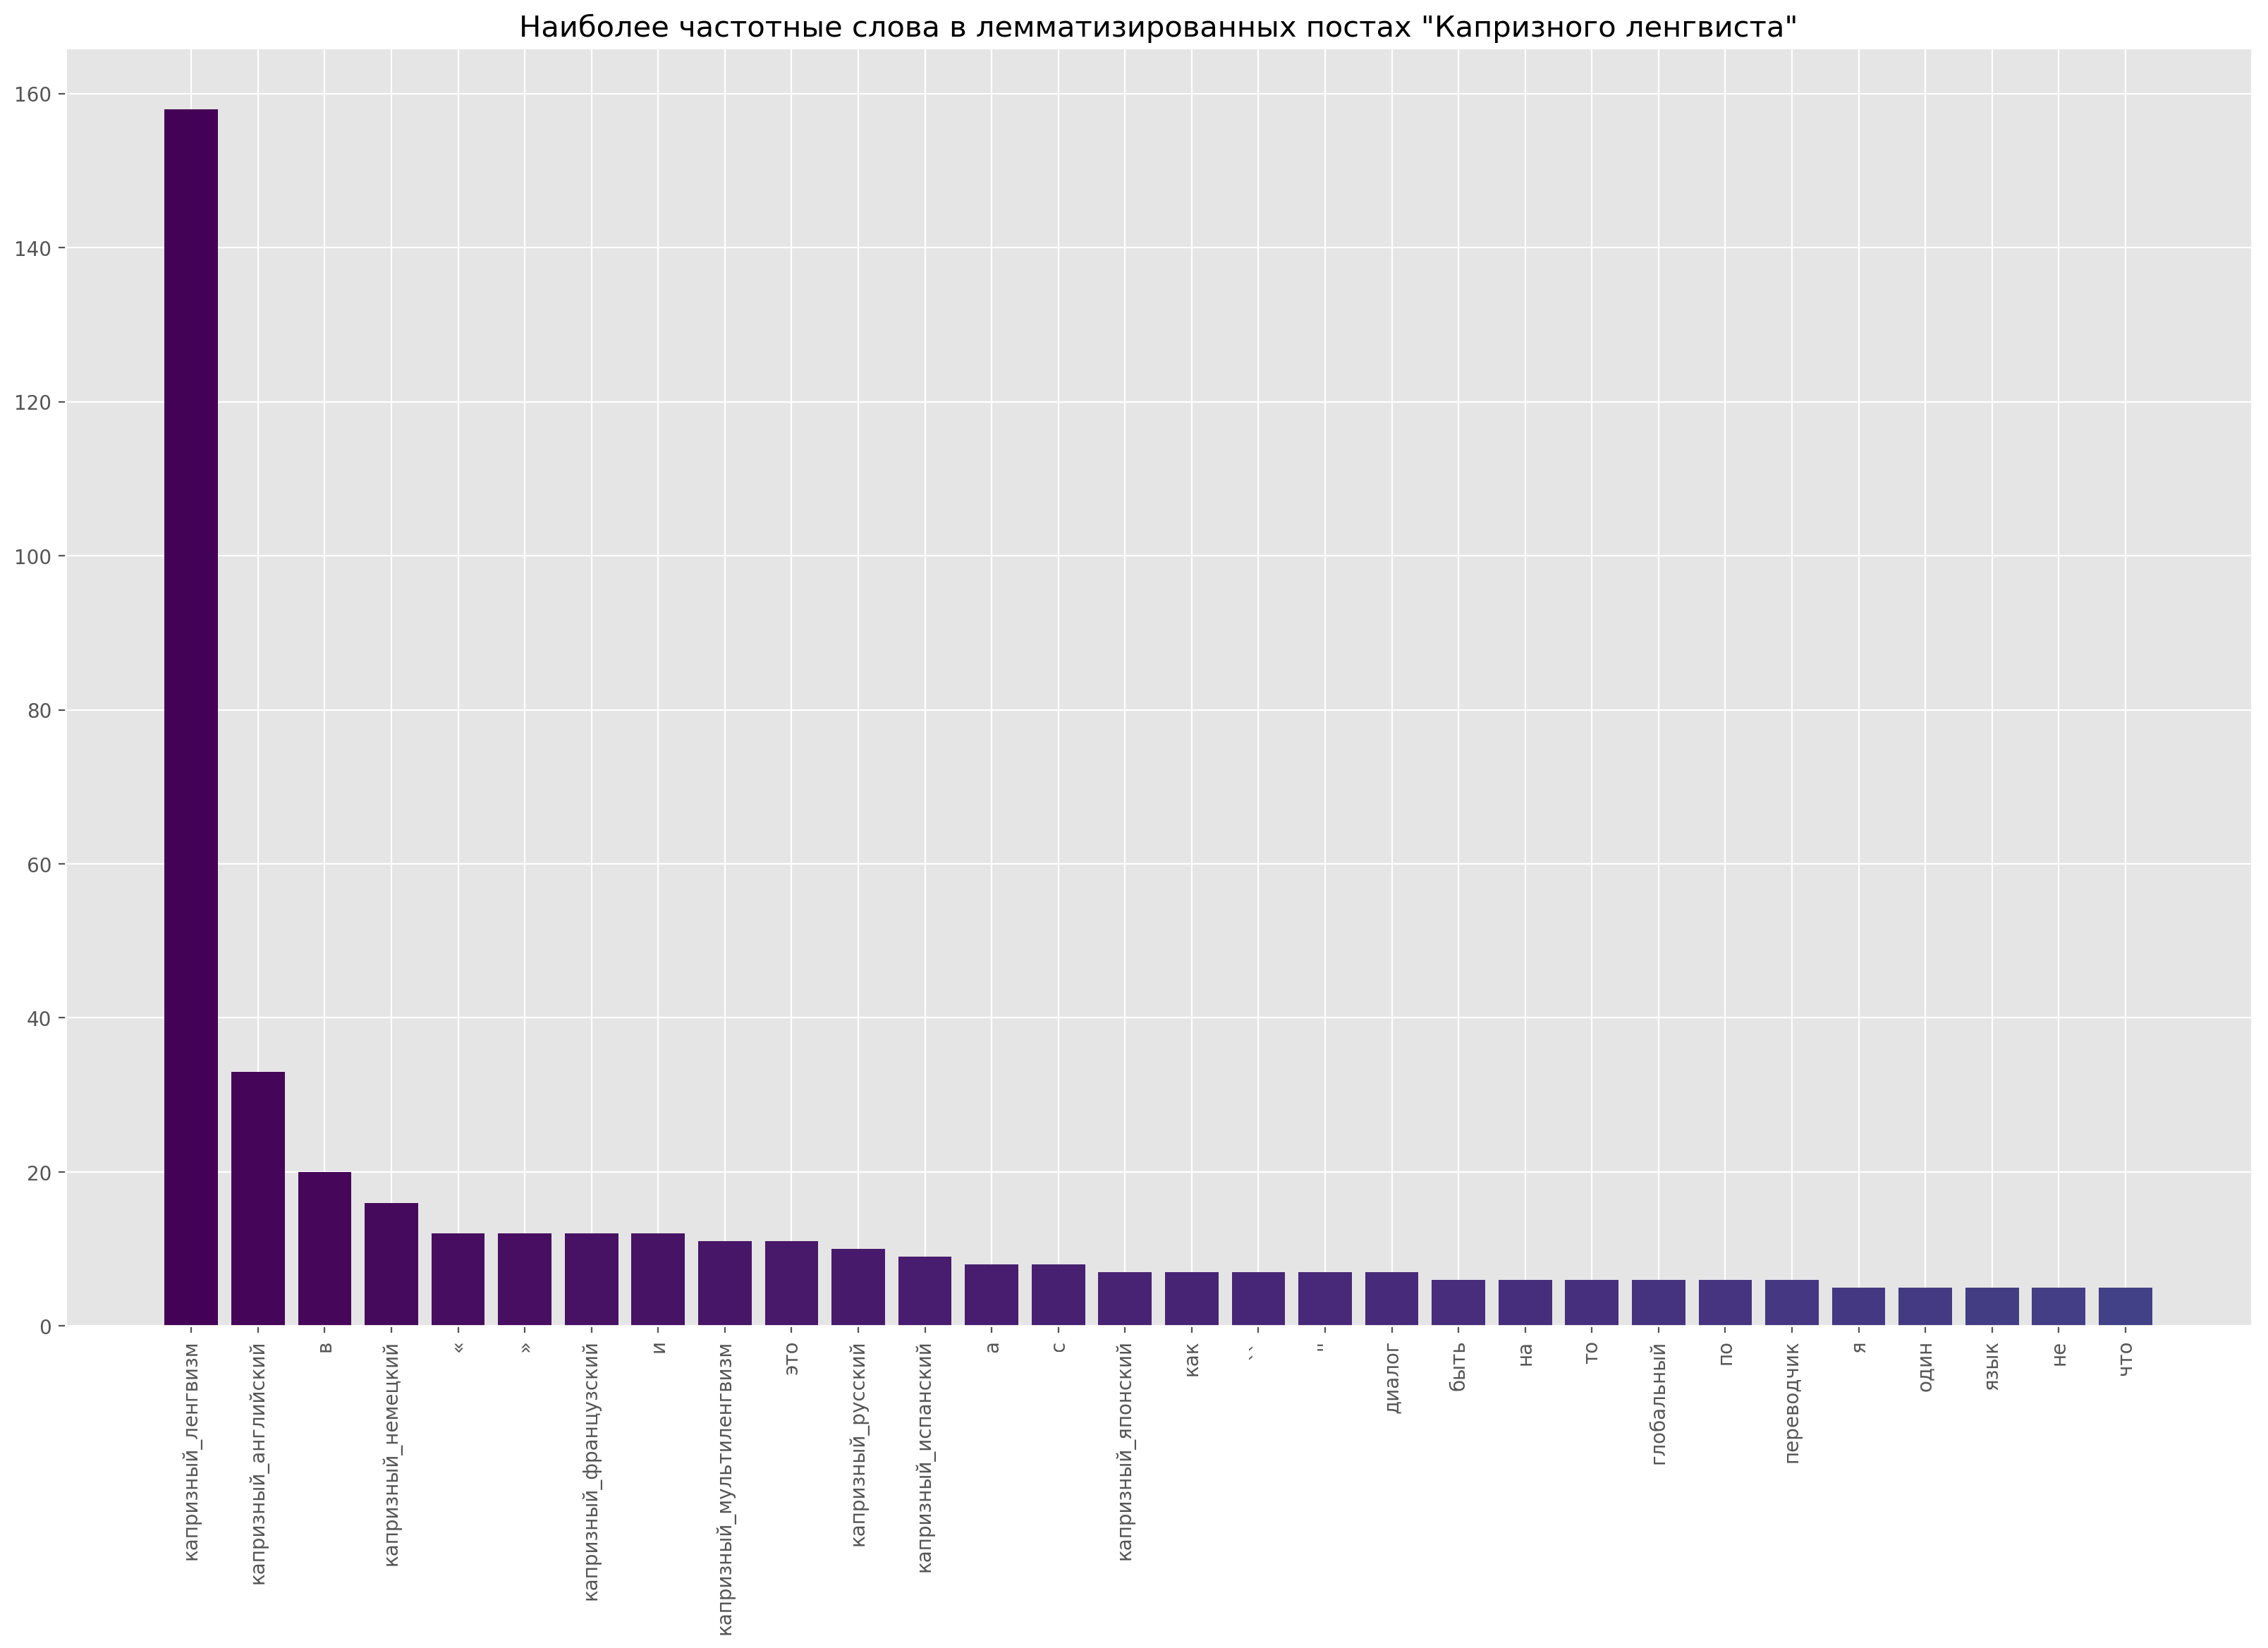

In [151]:
word_count = Counter(clean_posts).most_common(30)
words = [w[0] for w in word_count]
numbers = [w[1] for w in word_count]

colors = sns.color_palette('viridis', max(numbers)) 
plt.figure(figsize=(20, 12), dpi=200)
plt.bar(words, numbers, color=colors)
plt.title('Наиболее частотные слова в лемматизированных постах "Капризного ленгвиста"', fontsize=15)
plt.xticks(rotation=90, fontsize= 10)
plt.savefig('lemmas_posts.png')

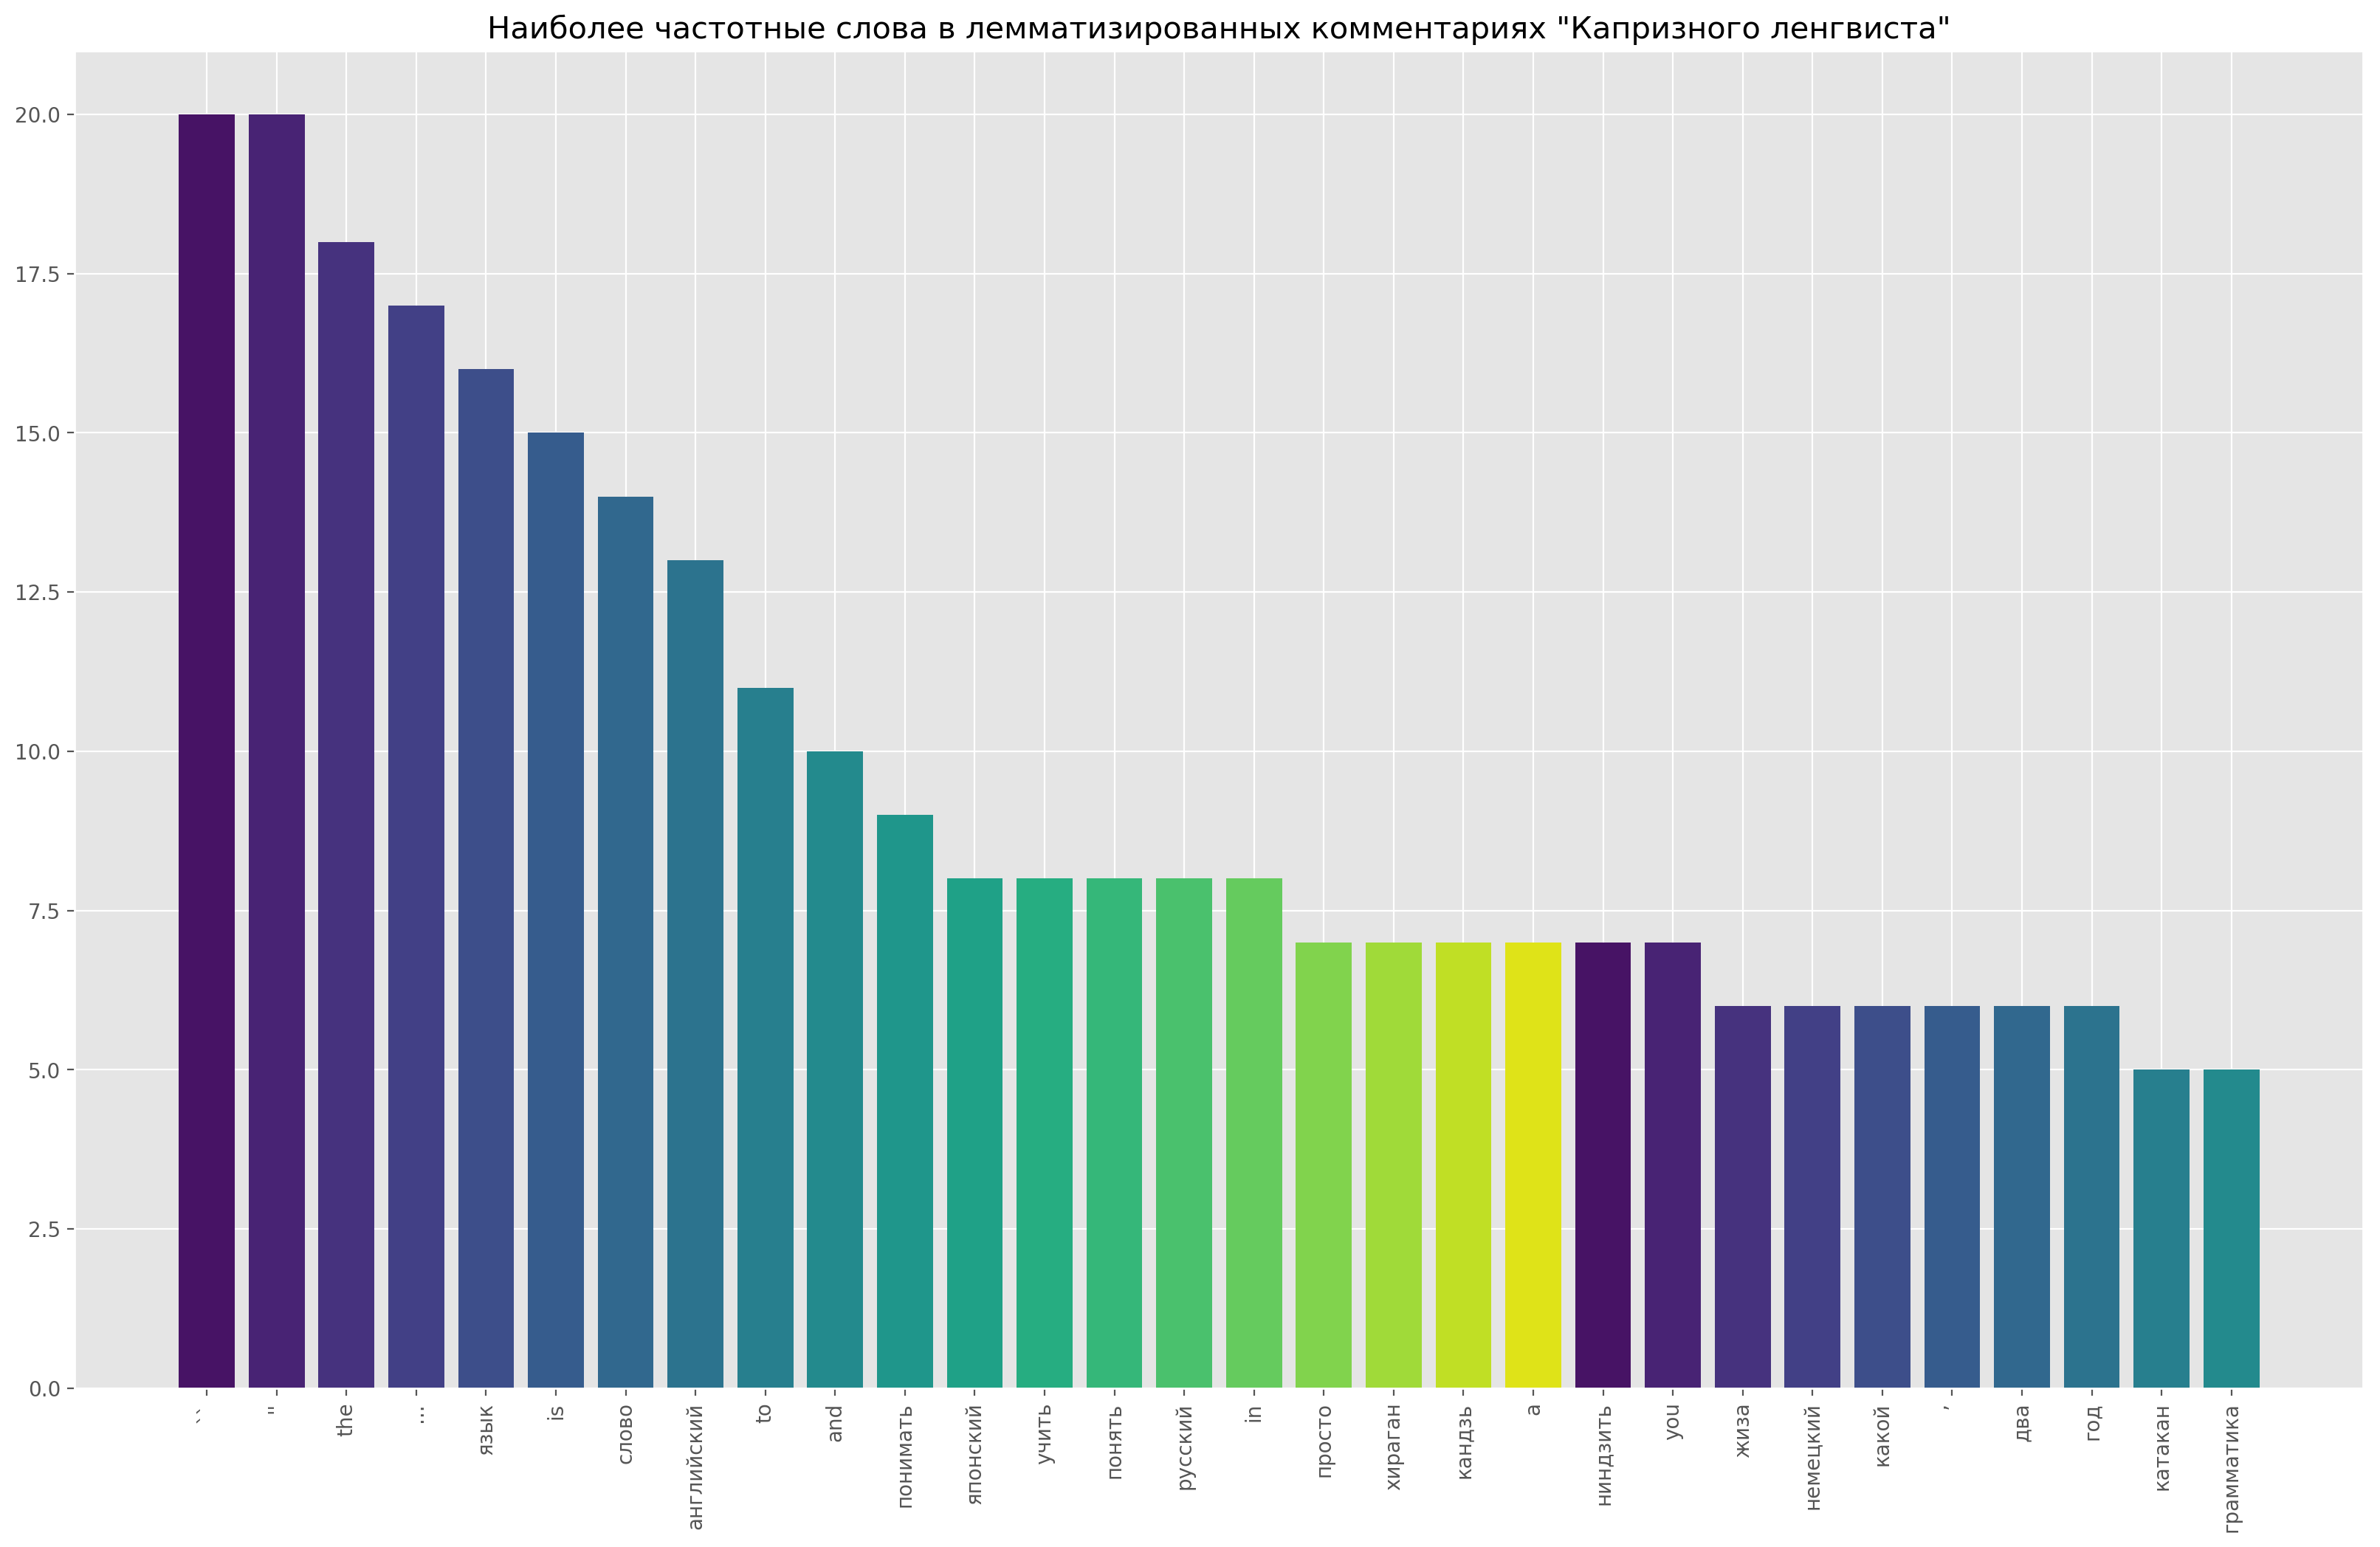

In [152]:
clean_comments = [morph.parse(token)[0].normal_form for token in comment_corpus]
word_count = Counter(clean_comments).most_common(30)
words = [w[0] for w in word_count]
numbers = [w[1] for w in word_count]

colors = sns.color_palette('viridis', max(numbers)) 
plt.figure(figsize=(20, 12), dpi=200)
plt.bar(words, numbers, color=colors)
plt.title('Наиболее частотные слова в лемматизированных комментариях "Капризного ленгвиста"', fontsize=15)
plt.xticks(rotation=90, fontsize= 10)
plt.savefig('lemmas_comments.png')

### Облако слов

In [166]:
corpus = ' '.join(clean_posts + clean_comments)

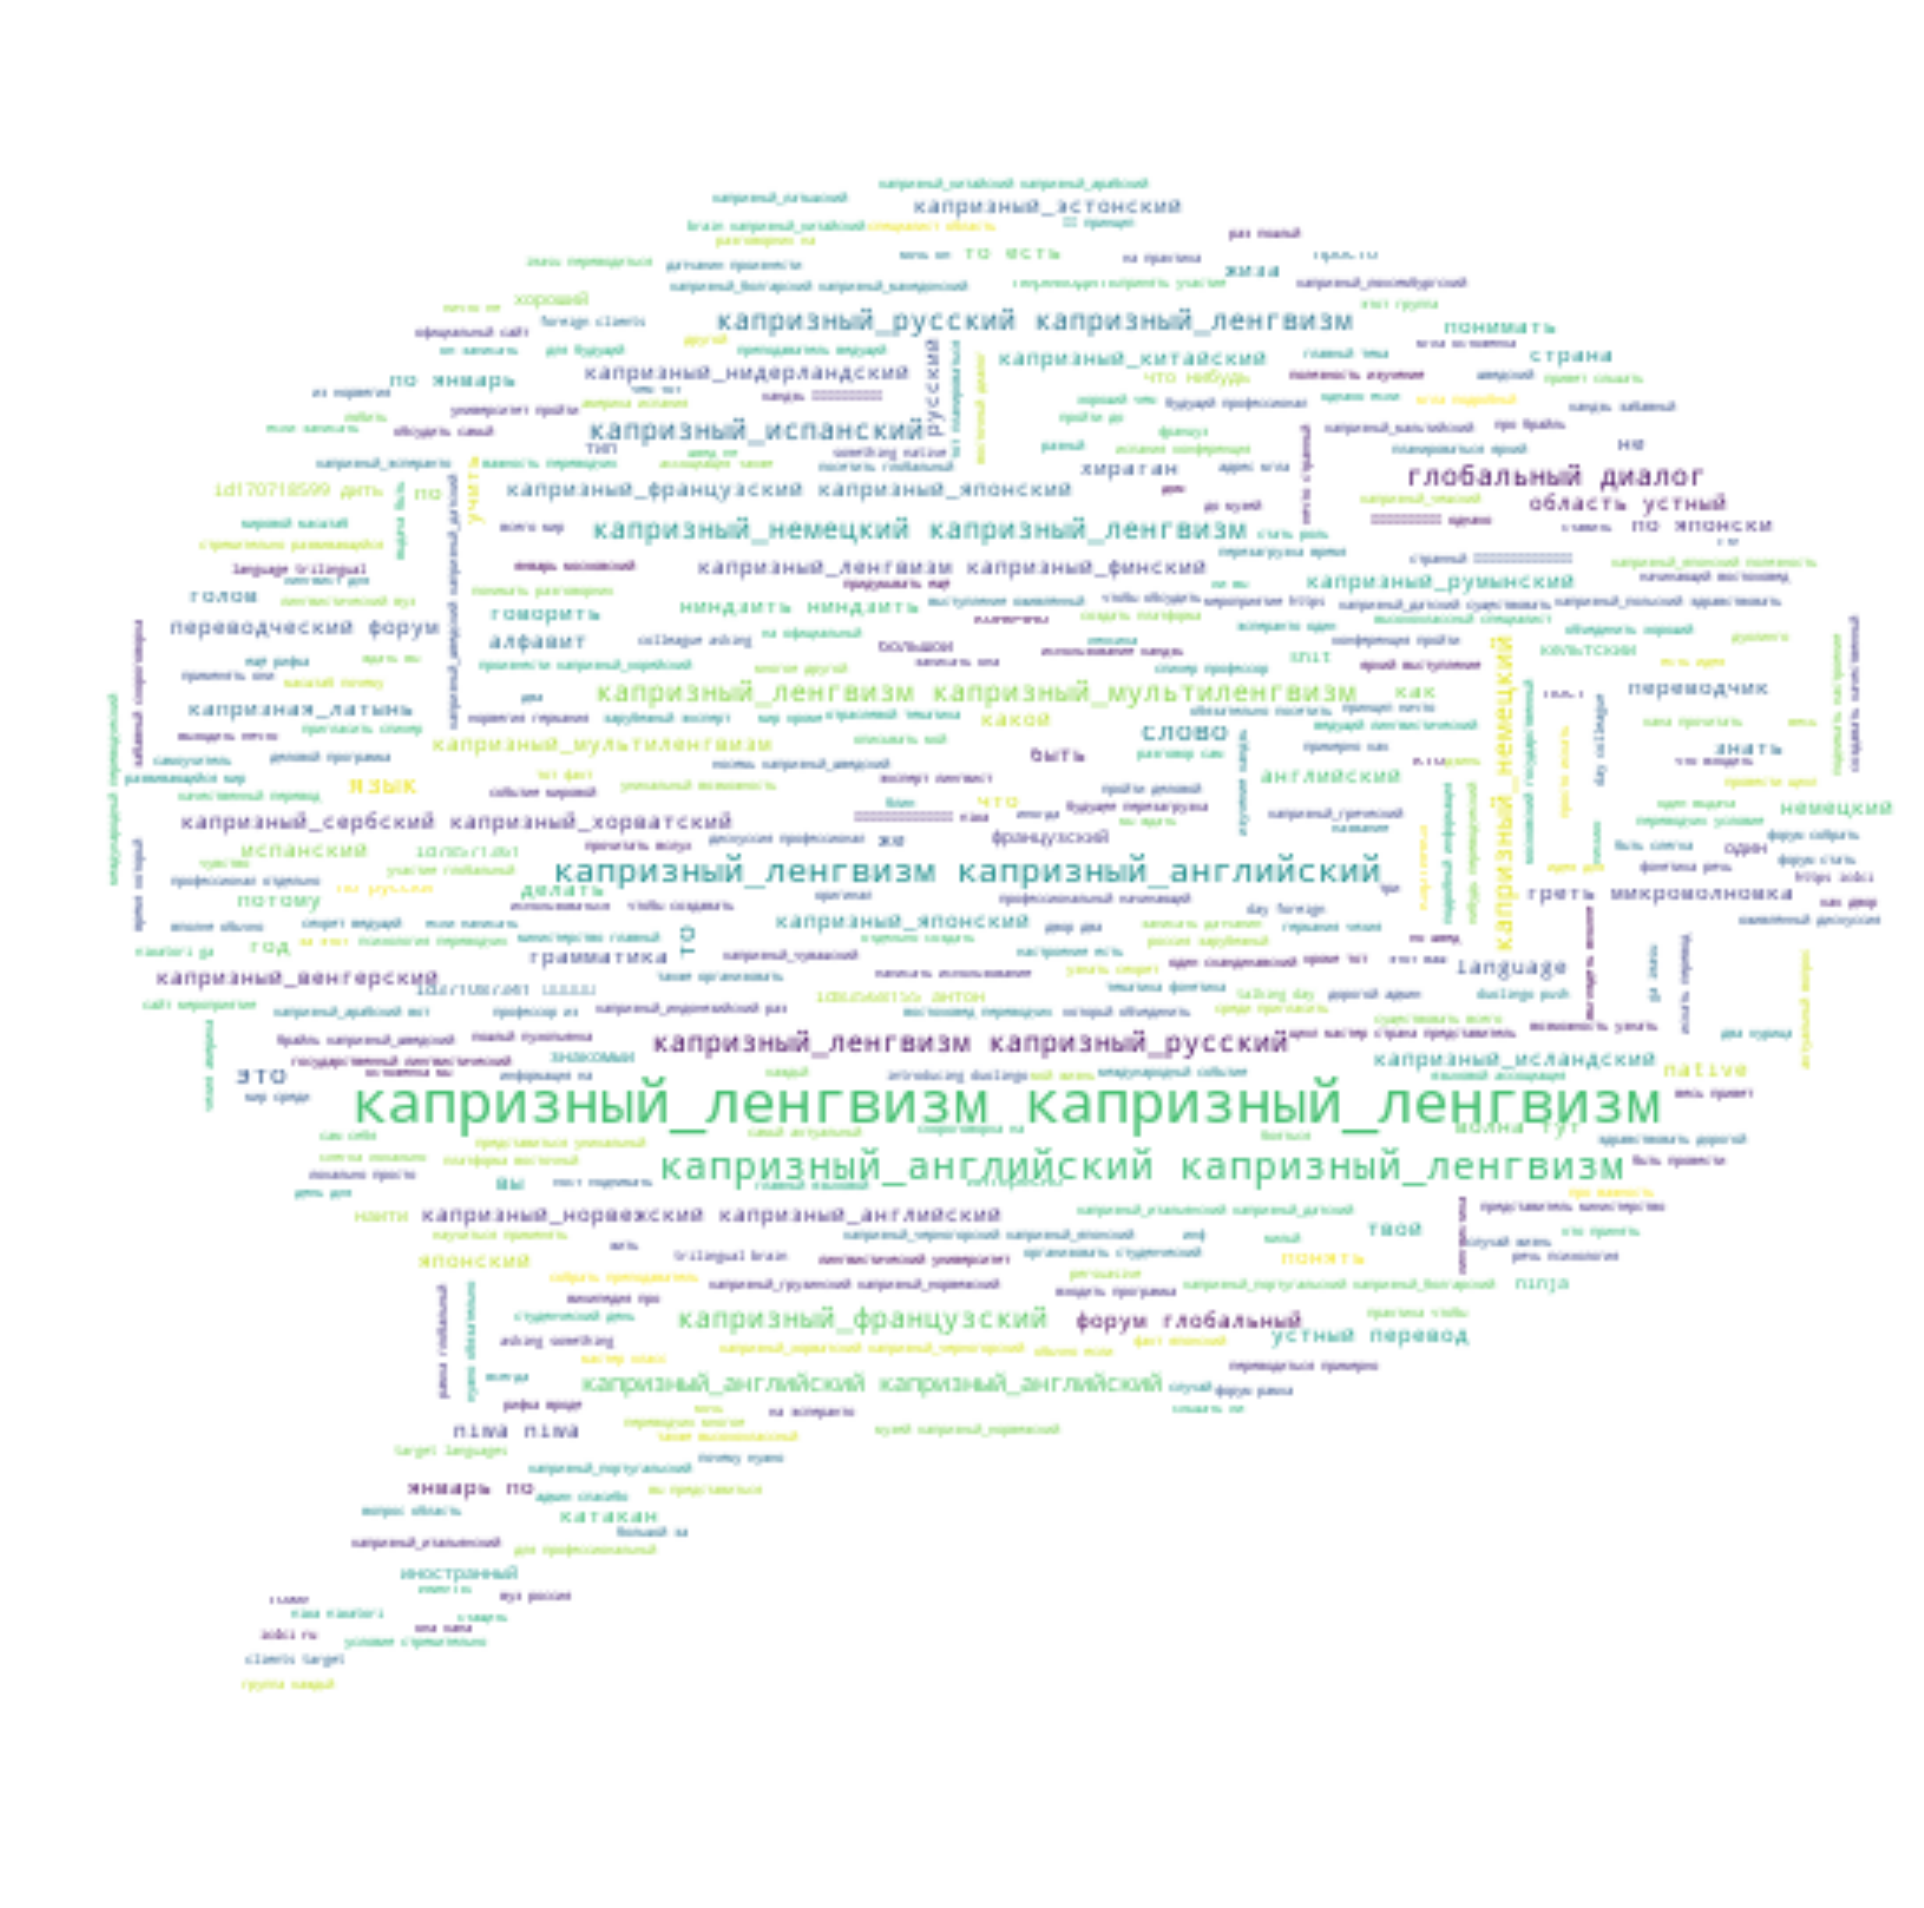

In [169]:
from wordcloud import WordCloud
from PIL import Image
import numpy as np
comment_mask = np.array(Image.open("comment.jpg"))
cloud = WordCloud(background_color="white", max_words=2000, mask=comment_mask)
cloud.generate(corpus)
plt.figure(figsize=(20, 12), dpi=200)
plt.imshow(cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

cloud.to_file("corpus_wordcloud.png")

[[],
 ['капризный_ленгвизм'],
 ['капризный_мультиленгвизм'],
 ['капризный_ленгвизм'],
 ['капризный_индонезийский', 'раз', 'пошла', 'пухопьянка'],
 ['капризный_немецкий'],
 ['капризный_ленгвизм'],
 ['капризный_ленгвизм'],
 ['капризный_китайский'],
 ['капризный_ленгвизм'],
 ['капризный_ленгвизм'],
 ['капризный_ленгвизм'],
 ['капризный_английский'],
 ['капризный_ленгвизм'],
 ['капризный_ленгвизм'],
 ['капризный_ленгвизм'],
 ['капризный_ленгвизм',
  'me',
  'talking',
  'all',
  'day',
  'with',
  'foreign',
  'clients',
  'in',
  'my',
  'target',
  'languages*',
  'at',
  'the',
  'and',
  'of',
  'the',
  'day',
  'my',
  'colleague',
  'asking',
  'me',
  'something',
  'in',
  'my',
  'native',
  'language*',
  'my',
  'trilingual',
  'brain'],
 ['капризный_китайский'],
 ['капризный_ленгвизм'],
 ['капризный_ленгвизм'],
 ['капризный_ленгвизм',
  'это',
  'может',
  'быть',
  'слегка',
  'локально',
  'я',
  'просто',
  'искала',
  'перевод',
  'слова',
  'на',
  'эсперанто',
  'а',
  '

In [184]:
with open('words_corpus.txt', 'w', encoding='utf-8') as f:
    f.write('\n'.join([' '.join(t) for t in (post_texts + comment_texts)]))

In [187]:
with open('lemmatized_corpus.txt', 'w', encoding='utf-8') as f:
    f.write(' '.join(clean_posts + clean_comments))